In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function, absolute_import
import pickle
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from edfreader import read_edf
import numpy as np
from lmfit import  Model, Parameters
%matplotlib inline

In [2]:
timeStr = '2017-07-21_142241'
observer = 'laurent'
mode = 'enregistrement'

In [3]:
file = os.path.join('..', 'data', mode + '_' + observer + '_' + timeStr + '.pkl')
with open(file, 'rb') as fichier :
    exp = pickle.load(fichier, encoding='latin1')
      
resultats = os.path.join('..', 'data', mode + '_' + observer + '_' + timeStr + '.asc')
data = read_edf(resultats, 'TRIALID')

In [4]:
N_trials = exp['N_trials']
N_blocks = exp['N_blocks']
screen_width_px = exp['screen_width_px']
screen_height_px = exp['screen_height_px']
V_X = exp['V_X']
RashBass = exp['RashBass']
stim_tau = exp['stim_tau']
p = exp['p']

In [5]:
def vitesse (x, tau=0.013, xT=0.01, t_T=0.2, start=1200., bino=1) :
    '''
    tau -- constante oeuil (0.013)
    xT -- position en deg de la cible (1)
    t_T -- tps du mvt - s (0.1)
    start -- tps où commence le mvt
    bino -- binomial
    '''    
    if bino == 0:
        xT =xT*(-1)
    
    dt = 0.001
    T = int(t_T/dt) # tps termine mvt - ms
    time = np.arange(len(x))/1000 # en seconde !!!
    start = start/1000 # en seconde
    rho = tau/t_T*np.log((1+np.exp(t_T/tau))/2) # proportion accélération dans mvt
    
    Umax = 1/tau*xT/((2*rho-1)*t_T-tau*(2-np.exp(-rho*t_T/tau)-np.exp((1-rho)*t_T/tau))) # signal N

    vitesse = []
    for t in range(len(time)):
        if bino==0 :
            if Umax*tau*(1-np.exp(-1/tau*(time[t]-start))) > 0 :
                vitesse.append(0)
            else :
                vitesse.append(Umax*tau*(1-np.exp(-1/tau*(time[t]-start))))
        else :
            if Umax*tau*(1-np.exp(-1/tau*(time[t]-start))) < 0 :
                vitesse.append(0)
            else :
                vitesse.append(Umax*tau*(1-np.exp(-1/tau*(time[t]-start))))
    return vitesse

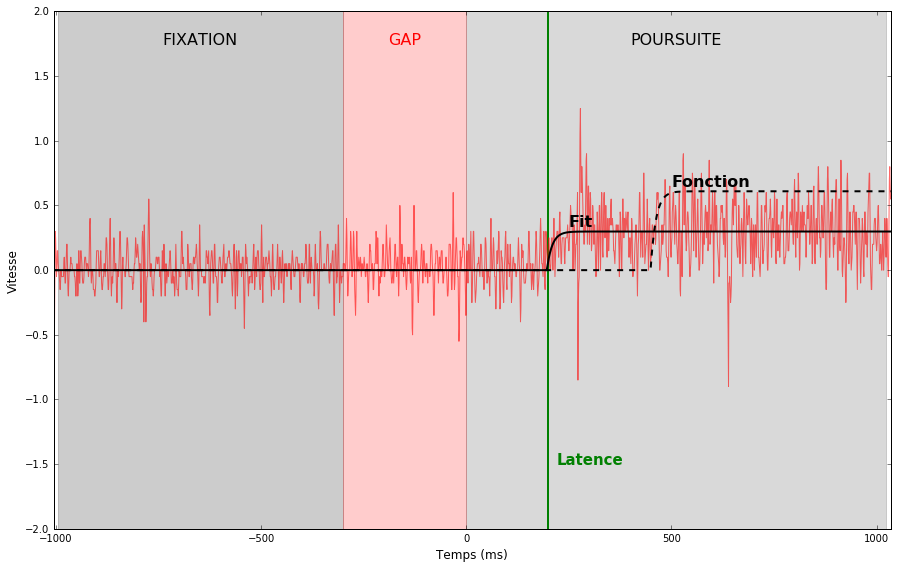

In [80]:
fig_width= 15
fig, axs = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.6180))
block = 0    
trial = 0

trial_data = trial + N_trials*block

data_x = data[trial_data]['x']
data_y = data[trial_data]['y']
trackertime = data[trial_data]['trackertime']

StimulusOn = data[trial_data]['events']['msg'][10][0]
StimulusOf = data[trial_data]['events']['msg'][14][0]
TargetOn = data[trial_data]['events']['msg'][15][0]
TargetOff = data[trial_data]['events']['msg'][16][0]
saccades = data[trial_data]['events']['Esac']

start = TargetOn

StimulusOn = StimulusOn - start
StimulusOf = StimulusOf - start
TargetOn = TargetOn - start
TargetOff = TargetOff - start
trackertime = trackertime - start
trackertime_0 = data[trial_data]['trackertime'][0]

gradient_x = np.gradient(data_x)

# SUPPRESSION DES SACCADES
new_gradient_x=[]
new_time=[]
t=0
for x_data in range(len(data_x)):
    saccade = None
    for s in range(len(saccades)) :
        if x_data in np.arange((saccades[s][0]-trackertime_0), (saccades[s][1]-trackertime_0+1+4)) :
            saccade = 'yes'
    if not saccade :
        new_gradient_x.append(gradient_x[x_data])
        new_time.append(t)
        t = t+1
    saccade = None


# FIT
model = Model(vitesse)

bino=p[trial, block, 0]
params = Parameters()
params.add('tau', value=0.013, min=0.001, max=0.1, vary=False)
params.add('xT', value=0.05, min=0.001, max=0.1)#, vary=False)
params.add('t_T', value= 0.1, min=0.001, max=0.2, vary=False)
params.add('start', value=1500., min=0, max=2000.)#, vary=True)
params.add('bino', value=bino, min=0, max=1, vary=False)

result = model.fit(new_gradient_x, params, x=new_time)

debut  = data[trial_data]['events']['msg'][15][0]-trackertime_0 # TargetOn - temps_0

axs.axis([StimulusOn-10, TargetOff+10, -2, 2])
axs.plot(np.asarray(new_time)-debut, new_gradient_x, color='r', alpha=0.6)
axs.plot(np.asarray(new_time)-debut, result.init_fit, 'k--', linewidth=2)
axs.plot(np.asarray(new_time)-debut, result.best_fit, color='k', linewidth=2)

axs.axvspan(StimulusOn, StimulusOf, color='k', alpha=0.2)
axs.axvspan(StimulusOf, TargetOn, color='r', alpha=0.2)
axs.axvspan(TargetOn, TargetOff, color='k', alpha=0.15)

latence = result.values['start']

# donne la latence sans la suppresion des saccades
new_latence = latence
for s in range(len(saccades)) :
    if new_latence > saccades[s][0]-trackertime_0 :
        new_latence = new_latence + saccades[s][2]

axs.bar(latence-debut, 4, bottom=-2, color='g', width=6, linewidth=0)

axs.text(StimulusOn+(StimulusOf-StimulusOn)/2, 1.75, "FIXATION", color='k', fontsize=16, horizontalalignment='center')
axs.text(StimulusOf+(TargetOn-StimulusOf)/2, 1.75, "GAP", color='r', fontsize=16, horizontalalignment='center')
axs.text(TargetOn+(TargetOff-TargetOn)/2, 1.75, "POURSUITE", color='k', fontsize=16, horizontalalignment='center')

axs.text(latence-debut+25, -1.5, "Latence", color='g', fontsize=15,  weight='bold')
axs.text(500, 0.65, "Fonction", color='k', fontsize=16, weight='bold')
axs.text(250, 0.34, "Fit", color='k', fontsize=16, weight='bold')
#axs[trial].text(StimulusOn+15, -2, "%s"%(result.fit_report()), color='k', fontsize=15)

axs.set_xlabel('Temps (ms)', fontsize=12)
axs.set_ylabel('Vitesse', fontsize=12)

In [20]:
axs.text?

In [6]:
for block in range(N_blocks) :
    fig_width= 12
    fig, axs = plt.subplots(N_trials, 1, figsize=(fig_width, (fig_width*(N_trials/2))/1.6180))
    
    for trial in range(N_trials) :
        
        trial_data = trial + N_trials*block

        data_x = data[trial_data]['x']
        data_y = data[trial_data]['y']
        trackertime = data[trial_data]['trackertime']

        StimulusOn = data[trial_data]['events']['msg'][10][0]
        StimulusOf = data[trial_data]['events']['msg'][14][0]
        TargetOn = data[trial_data]['events']['msg'][15][0]
        TargetOff = data[trial_data]['events']['msg'][16][0]
        saccades = data[trial_data]['events']['Esac']

        start = TargetOn

        StimulusOn = StimulusOn - start
        StimulusOf = StimulusOf - start
        TargetOn = TargetOn - start
        TargetOff = TargetOff - start
        trackertime = trackertime - start
        trackertime_0 = data[trial_data]['trackertime'][0]

        gradient_x = np.gradient(data_x)
        
        # SUPPRESSION DES SACCADES
        new_gradient_x=[]
        new_time=[]
        t=0
        for x_data in range(len(data_x)):
            saccade = None
            for s in range(len(saccades)) :
                if x_data in np.arange((saccades[s][0]-trackertime_0), (saccades[s][1]-trackertime_0+1+4)) :
                    saccade = 'yes'
            if not saccade :
                new_gradient_x.append(gradient_x[x_data])
                new_time.append(t)
                t = t+1
            saccade = None
        
        
        # FIT
        model = Model(vitesse)

        bino=p[trial, block, 0]
        params = Parameters()
        params.add('tau', value=0.013, min=0.001, max=0.1, vary=False)
        params.add('xT', value=0.05, min=0.001, max=0.1)#, vary=False)
        params.add('t_T', value= 0.1, min=0.001, max=0.2, vary=False)
        params.add('start', value=1000., min=0, max=2000.)#, vary=True)
        params.add('bino', value=bino, min=0, max=1, vary=False)

        result = model.fit(new_gradient_x, params, x=new_time)

        debut  = data[trial_data]['events']['msg'][15][0]-trackertime_0 # TargetOn - temps_0
        
        axs[trial].cla() # pour remettre ax figure a zero
        axs[trial].axis([StimulusOn-10, TargetOff+10, -2, 2])
        axs[trial].plot(np.asarray(new_time)-debut, new_gradient_x, color='r')
        axs[trial].plot(np.asarray(new_time)-debut, result.init_fit, 'k--')
        axs[trial].plot(np.asarray(new_time)-debut, result.best_fit, color='k')

        axs[trial].bar(StimulusOn, 4, bottom=-2, color='r', width=4, linewidth=0)
        axs[trial].bar(StimulusOf, 4, bottom=-2, color='r', width=4, linewidth=0)
        axs[trial].bar(TargetOn, 4, bottom=-2, color='k', width=4, linewidth=0)
        axs[trial].bar(TargetOff, 4, bottom=-2, color='k', width=4, linewidth=0)

        latence = result.values['start']

        # donne la latence sans la suppresion des saccades
        new_latence = latence
        for s in range(len(saccades)) :
            if new_latence > saccades[s][0]-trackertime_0 :
                new_latence = new_latence + saccades[s][2]
        
        axs[trial].bar(latence-debut, 4, bottom=-2, color='g', width=4, linewidth=0)
        axs[trial].text(StimulusOf+10, 1.5, "Latence = %s"%(new_latence-debut), color='r', fontsize=15)
        
        #axs[trial].text(StimulusOn+15, -2, "%s"%(result.fit_report()), color='k', fontsize=15)
        
        axs[trial].set_xlabel('Time (ms)', fontsize=9)
        axs[trial].set_ylabel(trial+1, fontsize=9)

    plt.tight_layout() # pour supprimer les marge trop grande
    plt.subplots_adjust(hspace=0) # pour enlever espace entre les figures

    plt.savefig('figures/Fit_vitesse_%s_%s_block-%s_%s-trials.pdf'%(observer, timeStr, block+1, N_trials))
plt.close()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
